<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [4]:
# ANSWER
titanic_csv = '../../DATA/titanic_train.csv'

df = pd.read_csv(titanic_csv, index_col="PassengerId")

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [ ]:
# ANSWER

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [16]:
def null_rate(data):
    nulls = []
    nulls_pct = []
    for col in data.columns:
        nulls.append(data[col].isnull().sum())
        nulls_pct.append((data[col].isnull().sum()/data.shape[0]) * 100)
    table = pd.DataFrame({
        'Feature': data.columns,
        'Missing Values': nulls,
        '% Missing': nulls_pct
    }).sort_values(by='Missing Values', ascending=False)

    return table

null_rate(df)

,Feature,Missing Values,% Missing
9,Cabin,687,77.104377
4,Age,177,19.865320
10,Embarked,2,0.224467
0,Survived,0,0.000000
1,Pclass,0,0.000000
2,Name,0,0.000000
3,Sex,0,0.000000
5,SibSp,0,0.000000
6,Parch,0,0.000000
7,Ticket,0,0.000000


In [19]:
df['Embarked'].fillna('S', inplace=True)

In [21]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [30]:
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [33]:
df['Cabin_new'] = df.Cabin.apply(lambda x: x[:1] if type(x) is str else x)

<Axes: xlabel='Pclass'>

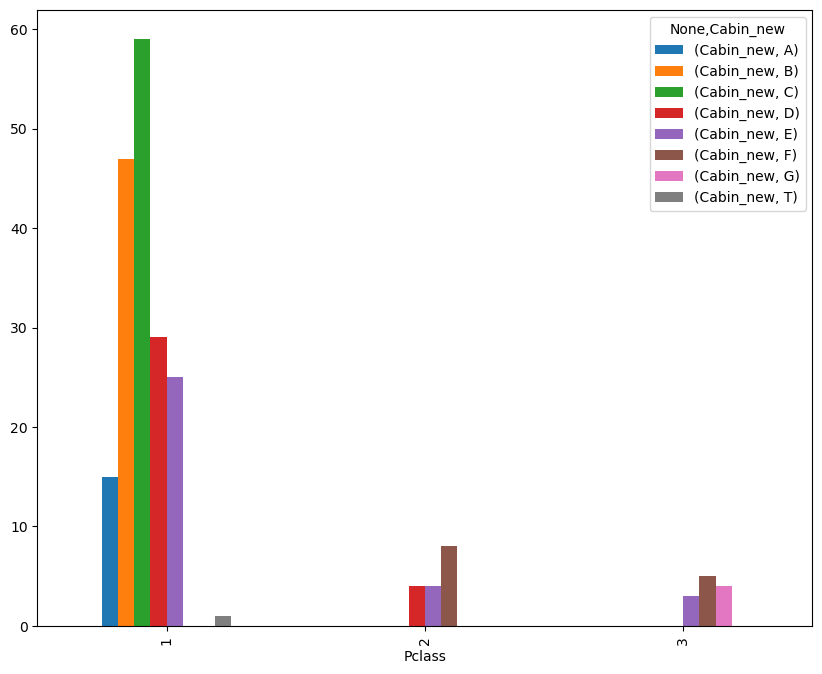

In [41]:
df.groupby(by=['Pclass','Cabin_new']).agg({'Cabin_new':'count'}).unstack().plot(kind = 'bar', figsize = (10,8))

In [37]:
df[df['Cabin_new'] == 'T']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_new
PassengerId,,,,,,,,,,,,
340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,T


In [42]:
df.drop(340, axis=0, inplace=True)

In [43]:
cabin_map = {
 'A':1,
  'B':2,
  'C':3,
   'D':4,
    'E':5,
    'F':6,
    'G':7
}

df['Cabin_new'] = df['Cabin_new'].map(cabin_map)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_new
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN


In [50]:
df['Cabin_new'].fillna(df.groupby(by=['Pclass'])['Cabin_new'].transform('mean'), inplace=True)

In [53]:
df['Cabin_new'] = np.round(df['Cabin_new'], decimals=0)

In [55]:
df.drop(['Cabin'], axis=1, inplace=True)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 1 to 891
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   890 non-null    int64  
 1   Pclass     890 non-null    int64  
 2   Name       890 non-null    object 
 3   Sex        890 non-null    object 
 4   Age        890 non-null    float64
 5   SibSp      890 non-null    int64  
 6   Parch      890 non-null    int64  
 7   Ticket     890 non-null    object 
 8   Fare       890 non-null    float64
 9   Embarked   890 non-null    object 
 10  Cabin_new  890 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 83.4+ KB


### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [59]:
X = df[['Pclass', 'Parch']]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [64]:
# ANSWER

seed = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [65]:
# ANSWER
# Create Model

lr = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [66]:
# ANSWER
# Fit Model

lr.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [67]:
# ANSWER

lr.coef_

array([[-0.90951911,  0.35262025]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [68]:
# ANSWER

lr.intercept_

array([1.43984683])

We can create tuples of the predictor names and coefficients like this:

In [71]:
# ANSWER
feature_cols = ['Pclass', 'Parch']
print(set(zip(feature_cols, lr.coef_[0])))

{('Parch', 0.3526202471564465), ('Pclass', -0.909519109446521)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [72]:
for col in zip(X_train.columns, lr.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.909519
Parch       +0.352620


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [92]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [81]:
# ANSWER

y_preds = lr.predict(X_test)

print("Confusion matrix\n", confusion_matrix(y_test, y_preds))

print("\nClassification report\n", classification_report(y_test, y_preds))

print("\nAccuracy score\n", accuracy_score(y_test, y_preds))

Confusion matrix
 [[89 21]
 [41 27]]

Classification report
               precision    recall  f1-score   support

           0       0.68      0.81      0.74       110
           1       0.56      0.40      0.47        68

    accuracy                           0.65       178
   macro avg       0.62      0.60      0.60       178
weighted avg       0.64      0.65      0.64       178


Accuracy score
 0.651685393258427


What is the  `accuracy_score` for the test data?

In [ ]:
# ANSWER

0.65

What can we say about this result?

ANSWER
- The model is only marginally better than flipping a coin. 
- 0.65 means that the model gets 65% of predictions right. 

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [84]:
# ANSWER

seed = 1 

X = df[['Pclass', 'Parch', 'Age']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [85]:
# Build Model

lr = LogisticRegression()

# Fit Model

lr.fit(X_train, y_train)

# Score

y_preds = lr.predict(X_test)

print("Confusion matrix\n", confusion_matrix(y_test, y_preds))

print("\nClassification report\n", classification_report(y_test, y_preds))

print("\nAccuracy score\n", accuracy_score(y_test, y_preds))

Confusion matrix
 [[90 20]
 [39 29]]

Classification report
               precision    recall  f1-score   support

           0       0.70      0.82      0.75       110
           1       0.59      0.43      0.50        68

    accuracy                           0.67       178
   macro avg       0.64      0.62      0.62       178
weighted avg       0.66      0.67      0.65       178


Accuracy score
 0.6685393258426966


In [87]:
df[['Survived', 'Age', 'Pclass', 'Parch']].corr()

,Survived,Age,Pclass,Parch
Survived,1.000000,-0.068842,-0.340458,0.081248
Age,-0.068842,1.000000,-0.329979,-0.178726
Pclass,-0.340458,-0.329979,1.000000,0.017636
Parch,0.081248,-0.178726,0.017636,1.000000


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- The feature Age may not have much relation to Survivability. 
- The model may be experiencing dimishing returns. 
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [90]:
# ANSWER
y_preds = lr.predict(X_test)
print(confusion_matrix(y_test, y_preds))

[[90 20]
 [39 29]]


Nb. Here is how `confusion_matrix` arranges its output:

In [ ]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

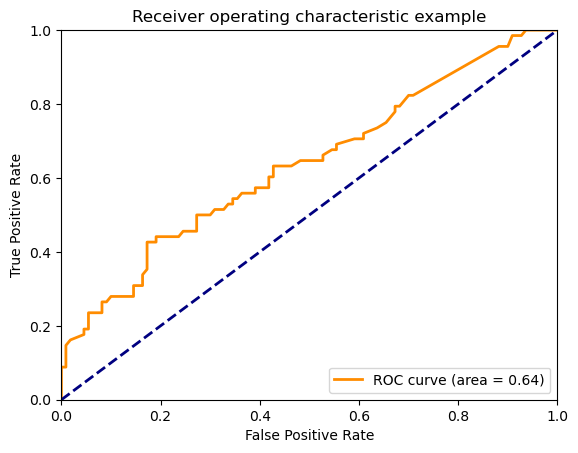

In [93]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [97]:
titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'],
                                      prefix = ['Sex', 'Embarked', 'Pclass'],)
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin_new,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,6.0,False,True,False,False,True,False,False,True
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3.0,True,False,True,False,False,True,False,False
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,6.0,True,False,False,False,True,False,False,True
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3.0,True,False,False,False,True,True,False,False
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,6.0,False,True,False,False,True,False,False,True


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [98]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [106]:
# ANSWER
# Set Feature Both Numerical, Categorical

seed = 1 

X = titanic_with_dummies[['Age', 'SibSp', 'Parch', 'Fare', 'Cabin_new', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Pclass_1', 'Pclass_2']]
y = titanic_with_dummies['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_preds = lr.predict(X_test)

print("Confusion matrix......................\n", confusion_matrix(y_test, y_preds))

print("\n\nClassification report................\n", classification_report(y_test, y_preds))

print("\nAccuracy score.......................\n", accuracy_score(y_test, y_preds))

Confusion matrix......................
 [[97 13]
 [21 47]]


Classification report................
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.69      0.73        68

    accuracy                           0.81       178
   macro avg       0.80      0.79      0.79       178
weighted avg       0.81      0.81      0.81       178


Accuracy score.......................
 0.8089887640449438


C:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Plot the ROC curve for the new model:

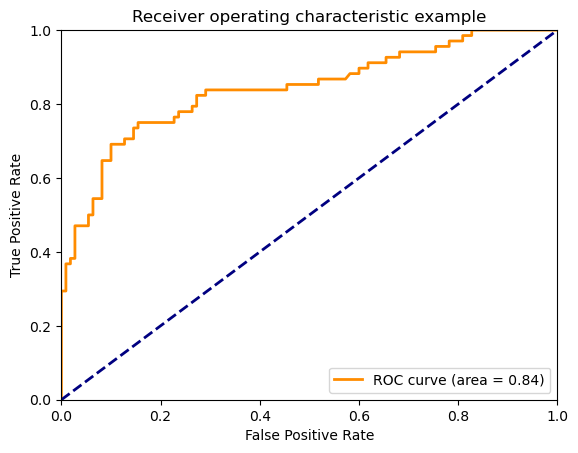

In [103]:
# ANSWER

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [ ]:
# ANSWER

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



